# Import Dependencies

In [ ]:
%pip install mlflow --quiet
%pip install pyngrok --quiet
%pip install pytorch-lightning==2.0.6 --quiet
%pip install pytorch-multilabel-balanced-sampler --quiet

In [2]:
import logging
import os
import warnings
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import mlflow.pytorch
import numpy as np
import pandas as pd
import plotly.express as px
import pytorch_lightning as pl
import torch
import torchvision
from pytorch_multilabel_balanced_sampler.samplers import RandomClassSampler
from sklearn.metrics import accuracy_score, classification_report, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchmetrics.classification import MultilabelAccuracy, MultilabelFBetaScore
from torchvision import transforms, utils
from torchvision.models import ResNet50_Weights, resnet50

warnings.filterwarnings("ignore")


logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)


# Setup Dataloader

In [4]:
training_labels = pd.read_csv(
    "/kaggle/input/planets-dataset/planet/planet/train_classes.csv"
)
IMG_DIR = Path("/kaggle/input/planets-dataset/planet/planet/train-jpg")

In [5]:
labels = training_labels["tags"].str.split()
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(labels)
print(mlb.classes_)
image_list = training_labels["image_name"]

['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']


In [6]:
training_labels.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [7]:
class AmazonDataset(Dataset):
    def __init__(self, image_dir: Path, image_list: list[str], y_train, transform=None):
        self.img_dir = image_dir
        self.y_train = y_train
        self.transform = transform
        self.id = image_list

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        img_name = self.img_dir / f"{self.id[idx]}.jpg"
        image = cv2.imread(str(img_name))
        if self.transform is not None:
            image = self.transform(image)
        label = torch.from_numpy(self.y_train[idx])
        return image, label

In [8]:
SEED = 42
torch.manual_seed(SEED)

# Normalize images to ImageNet since the model is pretrained on it.
# Resize to 224 since ResNet was trained on this size. 
base_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 244)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

rotational_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 244)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


amazon_data = AmazonDataset(IMG_DIR, image_list, y_train, base_transform)
amazon_data_with_rotations = AmazonDataset(
    IMG_DIR, image_list, y_train, rotational_transform
)


In [9]:
VAL_SIZE = 0.2
BATCH_SIZE = 64

image_indexes = image_list.index.to_numpy()

# generate indices, which also align with image ids.
train_indices, val_indices, _, _ = train_test_split(
    image_indexes, y_train, test_size=VAL_SIZE, random_state=SEED
)

# generate subset based on indices
train_split = Subset(amazon_data, train_indices)
train_split_with_rotations = Subset(amazon_data_with_rotations, train_indices)
val_split = Subset(amazon_data, val_indices)

In [ ]:
y_train_for_sampler = []
for i in range(len(train_indices)):
    y_train_for_sampler.append(train_split_with_rotations[i][1].numpy().tolist())
    
random_class_sampler = RandomClassSampler(labels=torch.tensor(y_train_for_sampler), indices=range(len(train_indices)))

In [36]:
# create Dataloaders
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
train_loader_with_rotations = DataLoader(
    train_split_with_rotations, batch_size=BATCH_SIZE, shuffle=True
)
train_loader_with_rotations_and_class_sampling = DataLoader(
    train_split_with_rotations, batch_size=BATCH_SIZE, sampler=random_class_sampler
)
validation_loader = DataLoader(val_split, batch_size=BATCH_SIZE)

# Data Exploration
* Dataset is extremely unbalanced
* Haze and clear blend into each other.
* Roads and rivers can look similar 
* Many images have multiple labels
* Clear skies are overrepresented compared to haze, partly cloudy, and cloudy

In [44]:
def display_image_grid(images: list[str], labels: list[str]) -> None:
    '''Creates grid of images with their labels'''
    num_cols = 3
    num_rows = int(np.ceil(len(images) / num_cols))
    plt.rc("axes", grid=False)
    _, ax = plt.subplots(
        num_rows, num_cols, sharex="col", sharey="row", figsize=(20, 20)
    )
    for i, (image, label) in enumerate(zip(images, labels)):
        img = cv2.imread(str(IMG_DIR / f"{image}.jpg"))
        box = ax[divmod(i, num_cols)]
        box.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        box.set_title(label)
    plt.show()

### Display a sample of images and their labels

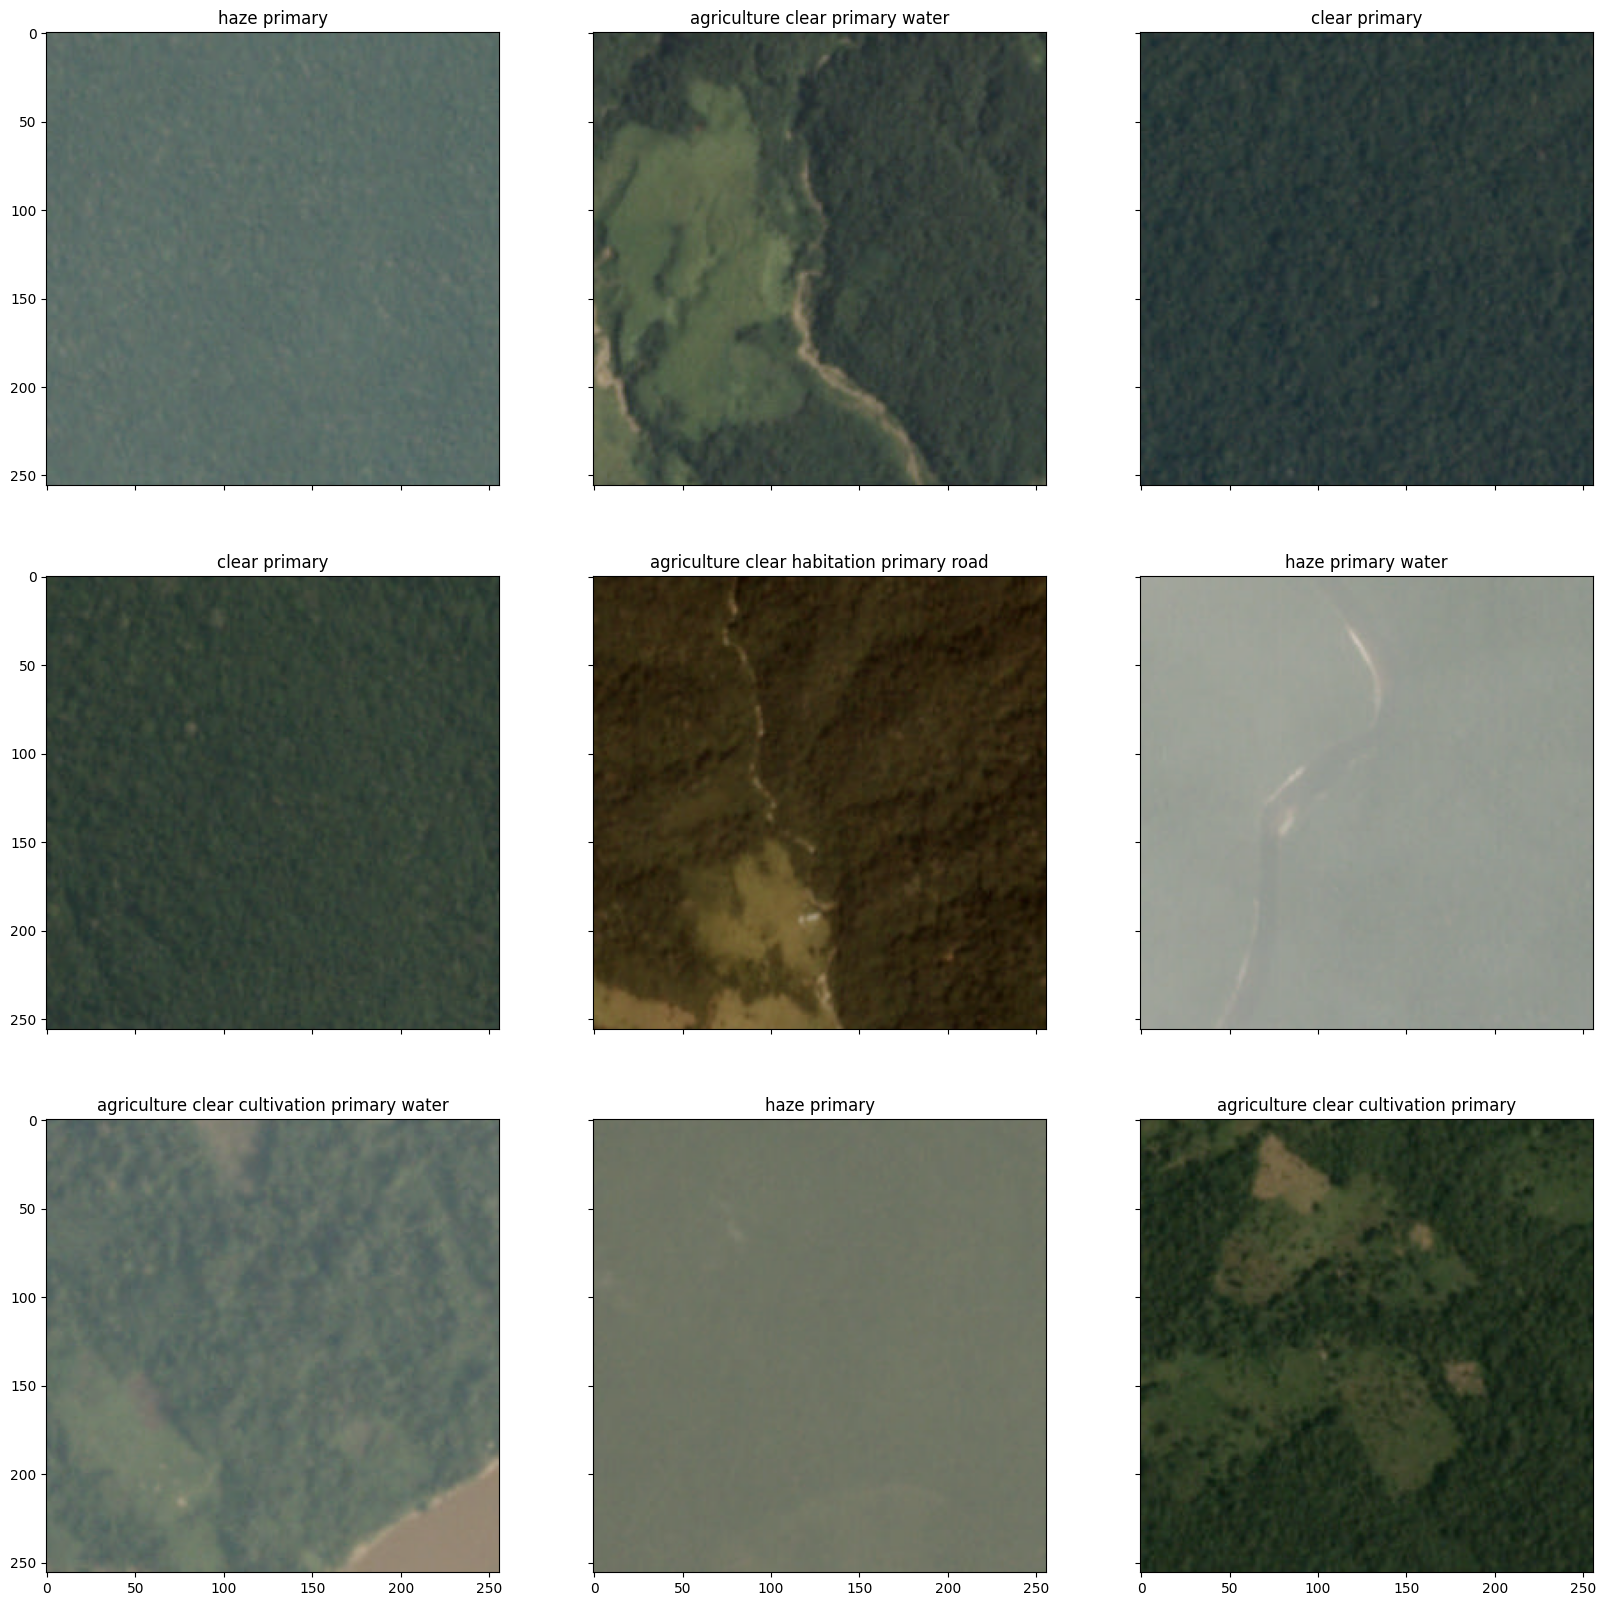

In [45]:
display_image_grid(
    images=training_labels["image_name"][:9], labels=training_labels["tags"][:9]
)

### Display one example of each label

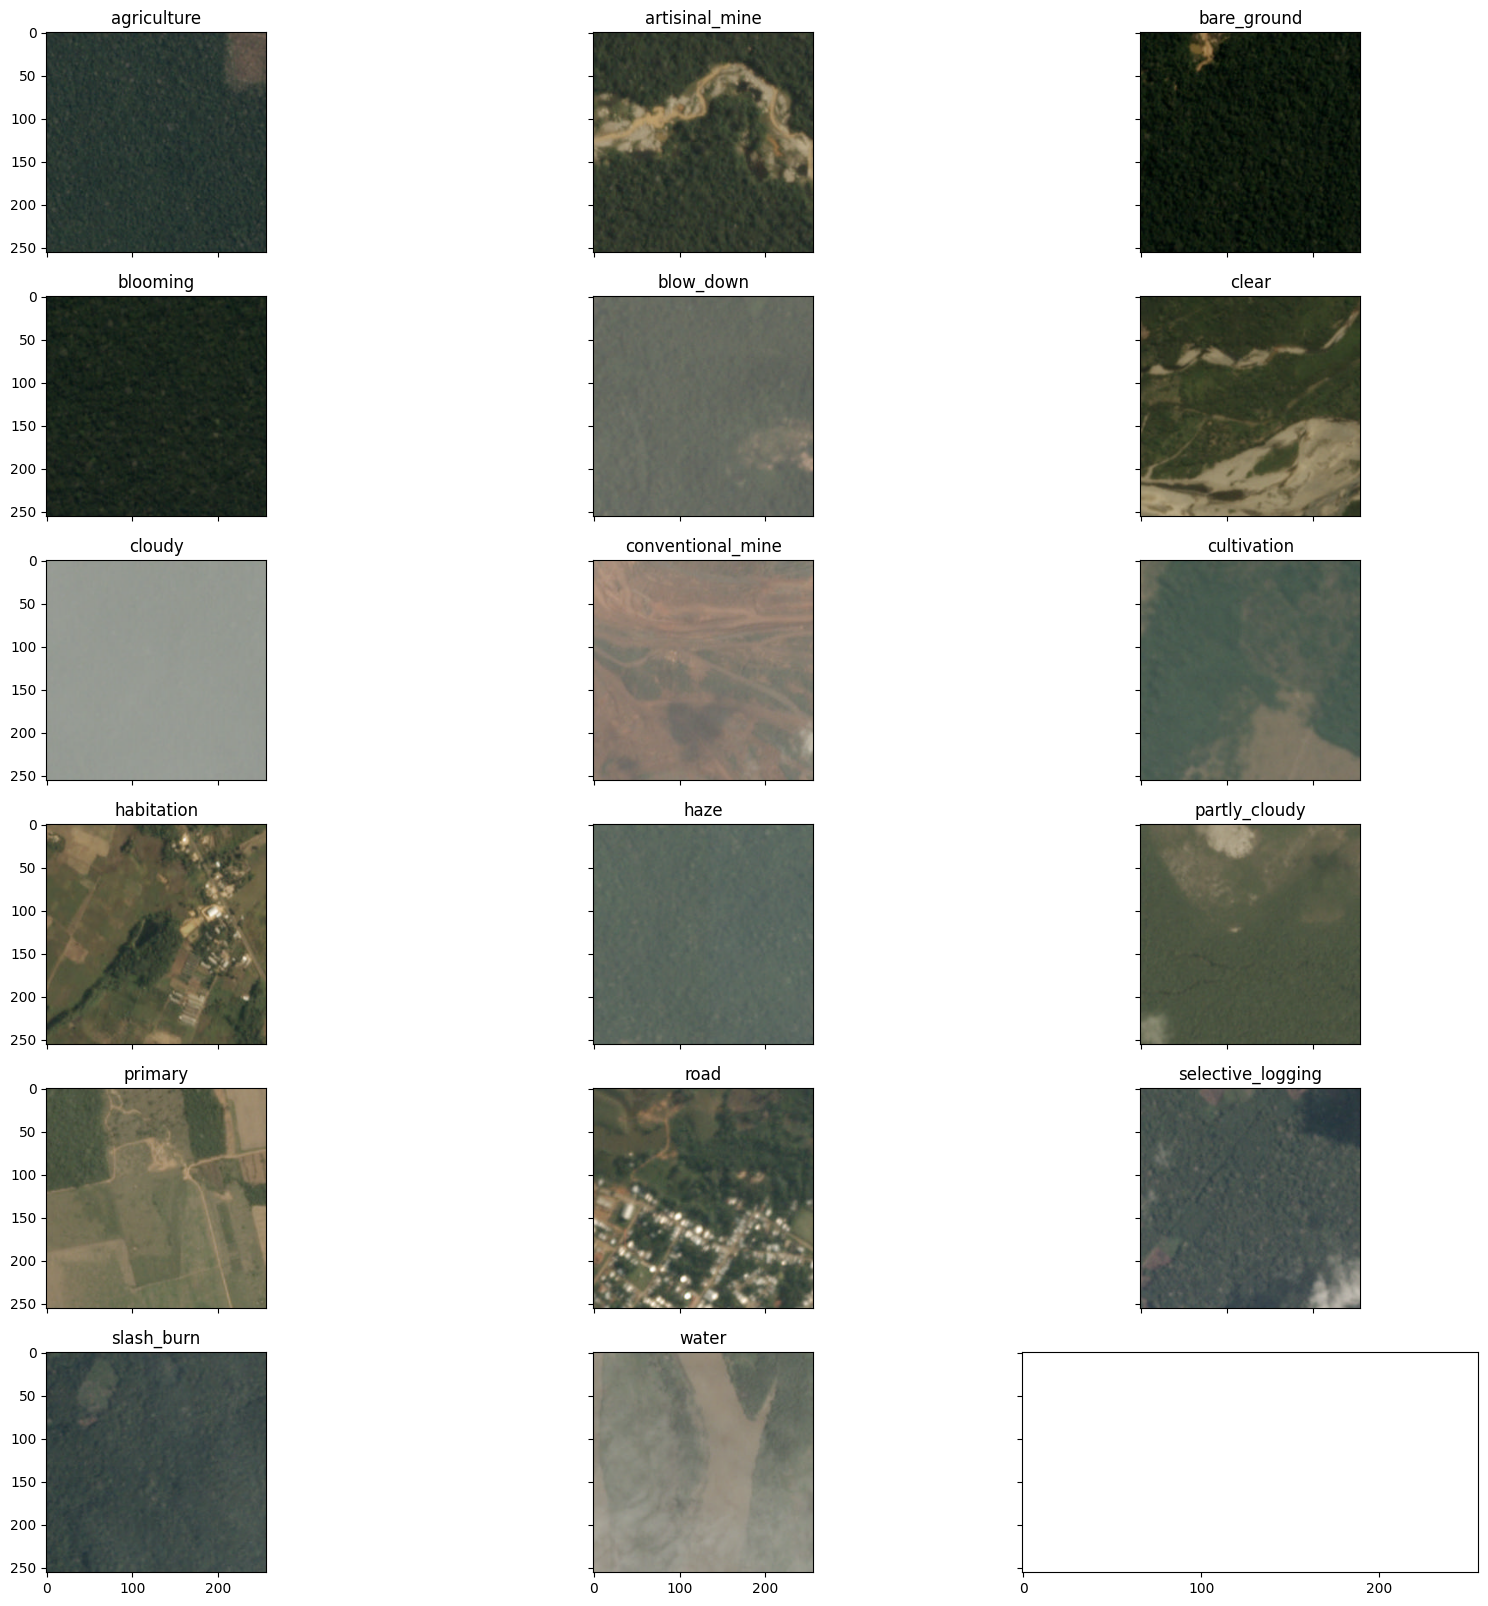

In [46]:
exploded_table = training_labels.copy(deep=True)
exploded_table["tags"] = exploded_table["tags"].str.split()
exploded_table = exploded_table.explode("tags")
one_sample_each = exploded_table.groupby('tags').sample(n=1)
display_image_grid(images=one_sample_each["image_name"], labels=one_sample_each["tags"])

### Analyze class imbalance

In [42]:
fig = px.histogram(
    data_frame=exploded_table["tags"],
    x="tags",
    title="Histogram of Tag Counts",
    color_discrete_sequence=["green"],
)
fig.update_xaxes(categoryorder="total descending")
fig.show()

## Analyze data imbalance between weather types

In [43]:
clouds_only = exploded_table[
    exploded_table["tags"].isin(["haze", "clear", "cloudy", "partly_cloudy"])
]
fig = px.histogram(
    data_frame=clouds_only["tags"],
    x="tags",
    title="Histogram of Cloud Tag Counts",
    color_discrete_sequence=["darkgray"],
)
fig.update_xaxes(categoryorder="total descending")
fig.show()

# Setup Model

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
accuracy_score = MultilabelAccuracy(num_labels=17, average="micro", threshold=0.5).to(
    device
)
multilabel_f2_score = MultilabelFBetaScore(
    beta=2.0, num_labels=17, average="micro", threshold=0.5
).to(device)


# Function for focal loss, taken from kaggle post. 
# https://www.kaggle.com/code/thedrcat/focal-multilabel-loss-in-pytorch-explained
# Gamma is set to 2 as paper suggests https://arxiv.org/abs/1708.02002
def focal_binary_cross_entropy(logits, targets, gamma=2):
    p = logits.reshape(-1)
    t = targets.reshape(-1)
    p = torch.where(t >= 0.5, p, 1 - p)
    logp = -torch.log(torch.clamp(p, 1e-4, 1 - 1e-4))
    loss = logp * ((1 - p) ** gamma)
    return 17 * loss.mean()

In [ ]:
class LitResNet(pl.LightningModule):
    def __init__(self, lr: float = 1e-4, loss_function: str = "BCELoss"):
        super().__init__()
        self.num_classes = 17
        self.model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.lr = lr
        self.model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.model.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, self.num_classes),
            nn.Sigmoid(),
        )
        if loss_function == "BCELoss":
            self.criterion = nn.BCELoss()
        elif loss_function == "FocalLoss":
            self.criterion = focal_binary_cross_entropy
        else:
            raise ValueError("Unsupported Loss Function")

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y.float())
        train_f2 = multilabel_f2_score(y_hat, y)
        train_acc = accuracy_score(y_hat, y)
        self.log_dict(
            {"train_loss": loss, "train_f2": train_f2, "train_acc": train_acc},
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y.float())
        val_f2 = multilabel_f2_score(y_hat, y)
        val_acc = accuracy_score(y_hat, y)
        self.log_dict(
            {"val_loss": loss, "val_f2": val_f2, "val_acc": val_acc},
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.model.parameters(), lr=self.lr, weight_decay=1e-5
        )

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        # This is necessary for pytorch lighting
        output = list(torch.argmax(self.model(x), dim=1))
        return self.model(x), y


## Metrics Report Pipeline

In [11]:
def unspool_predictions(predictions):
    '''Merge predictions and targets from trainer which come formatted by batch'''
    y_pred = np.vstack([prediction for prediction, _ in predictions])
    y_target = np.vstack([target for _, target in predictions])
    return y_pred, y_target

In [12]:
def metrics_report(predictions, threshold=0.5):
    '''Create report with sklearn classification report and a chart of recall by class'''
    y_pred, y_target = unspool_predictions(predictions)
    y_pred[y_pred >= threshold] = 1
    y_pred[y_pred < threshold] = 0

    print(classification_report(y_target, y_pred, target_names=mlb.classes_))

    report = classification_report(
        y_target, y_pred, output_dict=True, target_names=mlb.classes_
    )
    
    values = [[tag, report[tag]["recall"]] for tag in mlb.classes_]
    recall_values = pd.DataFrame(values, columns=["tag", "recall"])
    
    fig = px.bar(recall_values, x="tag", y="recall", title="Recall by Tag")
    fig.show()


# Setup MLFlow
* This was taken from this [kaggle notebook](https://www.kaggle.com/code/sharanharsoor/mlflow-end-to-end-ml-models )

In [41]:
# sets up mflow webpage
get_ipython().system_raw("mlflow ui --port 5000 &")
mlflow.pytorch.autolog()

In [ ]:
from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2UrnFGINS8aNan3KzPglzr0D2qx_5os1TDhjYTQEQYNNstZxg"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

# Baseline Model 
Starting out with the parameters that worked best for me when experimenting on classification for furniture. 
Run with .0001 LR, BCE loss, Two linear layer head, ResNet50, Batch Size 64

In [ ]:
mlflow.set_experiment("baseline")
model = LitResNet().to(device)
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_f2", min_delta=0.00, patience=3, verbose=False, mode="max")
trainer = pl.Trainer(log_every_n_steps=1, accelerator="gpu", devices=1, max_epochs=10, callbacks=[early_stop_callback])
with mlflow.start_run() as run:
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=validation_loader)

In [ ]:
trainer.validate(dataloaders=validation_loader, ckpt_path="best")

In [49]:
baseline_predictions = trainer.predict(model, validation_loader, ckpt_path="best")
metrics_report(baseline_predictions)

Predicting: 0it [00:00, ?it/s]

                   precision    recall  f1-score   support



      agriculture       0.84      0.79      0.82      2441

   artisinal_mine       0.82      0.73      0.77        70

      bare_ground       0.43      0.18      0.26       175

         blooming       0.47      0.12      0.20        64

        blow_down       0.50      0.04      0.07        25

            clear       0.96      0.97      0.96      5728

           cloudy       0.86      0.80      0.83       395

conventional_mine       1.00      0.23      0.37        22

      cultivation       0.66      0.43      0.52       864

       habitation       0.79      0.64      0.71       743

             haze       0.74      0.58      0.65       533

    partly_cloudy       0.89      0.93      0.91      1440

          primary       0.98      0.99      0.98      7507

             road       0.78      0.85      0.81      1568

selective_logging       0.53      0.16      0.25        61

       slash_burn       0.33      0.06

# Focal Loss for Class Imbalance
Testing using [Focal Loss](https://arxiv.org/abs/1708.02002) to encourage training to focus more on difficult examples compared to easier common examples. 
This only slightly improved the F2 score, and did not improve rare classes much. 


In [ ]:
mlflow.set_experiment("focal_loss")
model = LitResNet(loss_function="FocalLoss").to(device)
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_f2", min_delta=0.00, patience=3, verbose=False, mode="max")
focal_loss_trainer = pl.Trainer(log_every_n_steps=1, accelerator="gpu", devices=1, max_epochs=10, callbacks=[early_stop_callback])
with mlflow.start_run() as run:
    focal_loss_trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=validation_loader)

In [ ]:
focal_loss_trainer.validate(dataloaders=validation_loader, ckpt_path="best")

In [52]:
focal_predictions = focal_loss_trainer.predict(model, validation_loader, ckpt_path="best")
metrics_report(focal_predictions)

Predicting: 0it [00:00, ?it/s]

                   precision    recall  f1-score   support



      agriculture       0.82      0.83      0.83      2441

   artisinal_mine       0.75      0.77      0.76        70

      bare_ground       0.50      0.26      0.34       175

         blooming       0.19      0.22      0.21        64

        blow_down       0.60      0.12      0.20        25

            clear       0.96      0.96      0.96      5728

           cloudy       0.83      0.82      0.82       395

conventional_mine       0.92      0.55      0.69        22

      cultivation       0.49      0.57      0.52       864

       habitation       0.73      0.72      0.73       743

             haze       0.69      0.66      0.68       533

    partly_cloudy       0.89      0.92      0.90      1440

          primary       0.98      0.99      0.98      7507

             road       0.84      0.79      0.82      1568

selective_logging       0.37      0.36      0.37        61

       slash_burn       0.19      0.06

# Data Augmentation 
I use rotations and horiztonal/vertical flips. Cropping is not appropriate since it could crop out important features like buildings on the edge of the image. Color changes are risky since you need color to differentiate certain features like grass vs burnt ground or water vs roads. It could also cause confusion between haze and clear skies. Scale changes are not necessary since the images are all taken from the same distance, so it provides useful information that everything is the same size. 

In [ ]:
mlflow.set_experiment("rotations_augmentation")
model = LitResNet().to(device)
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_f2", min_delta=0.00, patience=3, verbose=False, mode="max")
rotation_trainer = pl.Trainer(log_every_n_steps=1, accelerator="gpu", devices=1, max_epochs=10, callbacks=[early_stop_callback])
with mlflow.start_run() as run:
    rotation_trainer.fit(model=model, train_dataloaders=train_loader_with_rotations, val_dataloaders=validation_loader)

In [ ]:
rotation_trainer.validate(dataloaders=validation_loader, ckpt_path="best")

In [55]:
augmented_predictions = rotation_trainer.predict(model, validation_loader, ckpt_path="best")
metrics_report(augmented_predictions)

Predicting: 0it [00:00, ?it/s]

                   precision    recall  f1-score   support



      agriculture       0.85      0.85      0.85      2441

   artisinal_mine       0.78      0.50      0.61        70

      bare_ground       0.58      0.20      0.30       175

         blooming       0.00      0.00      0.00        64

        blow_down       0.33      0.08      0.13        25

            clear       0.96      0.97      0.97      5728

           cloudy       0.85      0.85      0.85       395

conventional_mine       0.71      0.45      0.56        22

      cultivation       0.77      0.35      0.48       864

       habitation       0.85      0.59      0.70       743

             haze       0.77      0.66      0.71       533

    partly_cloudy       0.91      0.92      0.92      1440

          primary       0.98      0.99      0.98      7507

             road       0.88      0.81      0.84      1568

selective_logging       0.53      0.26      0.35        61

       slash_burn       0.00      0.00

# Random Sampling by Class for Class Imbalance
I found a [library](https://github.com/issamemari/pytorch-multilabel-balanced-sampler) that provides a pytorch sampler that randomly chooses a class to sample from, then chooses an element of that class. This should improve performance on the rare classes since they will be sampled more. It does have limitations that many images have mulitple classes so it cannot fully balance out the dataset. This did increase performance on rare classes, but it also reduced performance slightly on the common classes since they not being seen as much in training. 

In [ ]:
mlflow.set_experiment("Random Sampling")
model = LitResNet().to(device)
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_f2", min_delta=0.00, patience=3, verbose=False, mode="max")
class_sampling_trainer = pl.Trainer(log_every_n_steps=1, accelerator="gpu", devices=1, max_epochs=10, callbacks=[early_stop_callback])
with mlflow.start_run() as run:
    class_sampling_trainer.fit(model=model, train_dataloaders=train_loader_with_rotations_and_class_sampling, val_dataloaders=validation_loader)

In [ ]:
class_sampling_trainer.validate(dataloaders=validation_loader, ckpt_path="best")

In [40]:
class_sampling_predictions = class_sampling_trainer.predict(model, validation_loader, ckpt_path="best")
metrics_report(class_sampling_predictions)

Predicting: 0it [00:00, ?it/s]

                   precision    recall  f1-score   support



      agriculture       0.83      0.85      0.84      2441

   artisinal_mine       0.69      0.86      0.76        70

      bare_ground       0.30      0.43      0.35       175

         blooming       0.09      0.48      0.15        64

        blow_down       0.28      0.28      0.28        25

            clear       0.98      0.92      0.95      5728

           cloudy       0.79      0.89      0.84       395

conventional_mine       0.71      0.55      0.62        22

      cultivation       0.66      0.47      0.55       864

       habitation       0.76      0.75      0.75       743

             haze       0.58      0.76      0.66       533

    partly_cloudy       0.86      0.93      0.89      1440

          primary       0.98      0.98      0.98      7507

             road       0.83      0.82      0.82      1568

selective_logging       0.24      0.39      0.30        61

       slash_burn       0.18      0.11

# Long Running Model
The model was reaching maximum f2 score on epoch 2 which made me think it was learning the easy common classes quickly and needed more epochs to learn the rare classes. I tested running for 20 epochs and it reached maximum f2 score on epoch 10, but it only provided 0.002 improvement in f2 score. This extra score is not worth the risk of overtraining. Maybe training for many more epochs would gain an extra performance boost. 

In [ ]:
mlflow.set_experiment("long_running")
model = LitResNet().to(device)
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_f2", min_delta=0.00, patience=15, verbose=False, mode="max")
long_running_trainer = pl.Trainer(log_every_n_steps=1, accelerator="gpu", devices=1, max_epochs=20, callbacks=[early_stop_callback])
with mlflow.start_run() as run:
    long_running_trainer.fit(model=model, train_dataloaders=train_loader_with_rotations_and_class_sampling, val_dataloaders=validation_loader)

In [ ]:
long_running_trainer.validate(dataloaders=validation_loader, ckpt_path="best")

In [58]:
long_running_predictions = long_running_trainer.predict(model, validation_loader, ckpt_path="best")
metrics_report(long_running_predictions)

Predicting: 0it [00:00, ?it/s]

                   precision    recall  f1-score   support



      agriculture       0.81      0.85      0.83      2441

   artisinal_mine       0.74      0.71      0.72        70

      bare_ground       0.32      0.31      0.32       175

         blooming       0.12      0.53      0.19        64

        blow_down       0.28      0.28      0.28        25

            clear       0.98      0.93      0.95      5728

           cloudy       0.78      0.89      0.83       395

conventional_mine       0.69      0.41      0.51        22

      cultivation       0.54      0.59      0.56       864

       habitation       0.77      0.71      0.74       743

             haze       0.58      0.71      0.64       533

    partly_cloudy       0.87      0.93      0.89      1440

          primary       0.98      0.98      0.98      7507

             road       0.81      0.83      0.82      1568

selective_logging       0.33      0.25      0.28        61

       slash_burn       0.50      0.13

# Optimized Threshold
I tested various threshold values and found lowering it to .19 caused the maximum f2 score. If we cared more about precision, I could instead optimize to f0.5 score which would encourage a higher threshold. 

In [75]:
threshold_values = pd.DataFrame(columns=["threshold", "f2"])
best_threshold = 0
best_f2 = 0
for i in range(1, 100):
    y_pred, y_target = unspool_predictions(class_sampling_predictions)
    y_pred[y_pred >= i / 100] = 1
    y_pred[y_pred < i / 100] = 0
    fbeta = fbeta_score(y_target, y_pred, average="micro", beta=2)
    if fbeta > best_f2:
        best_threshold = i
        best_f2 = fbeta
    threshold_values.loc[len(threshold_values.index)] = [i, fbeta]
print(f"Best Threshold: {best_threshold:.2%} with F2 score: {best_f2:.3f}")

Best Threshold: 0.19 with F2 score: 0.902


In [65]:
fig = px.line(threshold_values, x="threshold", y="f2", title="F2 by Threshold")
fig.show()

In [71]:
metrics_report(class_sampling_predictions, threshold=best_threshold)

                   precision    recall  f1-score   support



      agriculture       0.73      0.93      0.82      2441

   artisinal_mine       0.58      0.90      0.71        70

      bare_ground       0.19      0.61      0.30       175

         blooming       0.08      0.77      0.14        64

        blow_down       0.24      0.40      0.30        25

            clear       0.97      0.96      0.96      5728

           cloudy       0.71      0.95      0.81       395

conventional_mine       0.56      0.64      0.60        22

      cultivation       0.42      0.76      0.54       864

       habitation       0.62      0.87      0.72       743

             haze       0.45      0.87      0.59       533

    partly_cloudy       0.82      0.96      0.89      1440

          primary       0.97      0.99      0.98      7507

             road       0.72      0.90      0.80      1568

selective_logging       0.17      0.52      0.25        61

       slash_burn       0.20      0.23